<a href="https://colab.research.google.com/github/SamuelOliveira/Colab/blob/main/FT084_2021S1_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://moodle.ggte.unicamp.br/pluginfile.php/1/core_admin/logocompact/300x300/1615465513/unicamp_transp_20180409.png" align="left" hspace="10px" vspace="0px"></p>

# Tarefa 2: Árvores de Decisão, Naïve Bayes, k-NN e Ensembles


**Enunciado:**

Dados os pacotes de software para classificação de dados identificados na tarefa anterior, pede-se:

* Escolha uma destas ferramentas, que tenha implementações de algoritmos de árvores de decisão, naïve Bayes e k-NN, e aplique estes **três algoritmos** ao conjunto de dados [Liver Disorder](http://goo.gl/QCuYTc):
  - Utilize subamostragem aleatória com 5 repetições para cada algoritmo e apresente o erro de classificação **médio** de cada um (para os conjuntos de testes);
  - Adote uma divisão de 70% dos dados para treinamento e 30% dos dados para teste;
  - Faça a amostragem antes de iniciar o treinamento e use os mesmos dados para todos os algoritmos (em cada repetição);
* Para cada repetição, monte um **ensemble** com os classificadores já treinados (via voto majoritário), aplique ao conjunto de testes e apresente o desempenho médio.

**ATENÇÃO**: Não se esqueça de apresentar no relatório os **parâmetros** definidos para cada algoritmo (caso existam)!

**Formato:**

*   Fonte: Times New Roman ou Calibri;
*   Tamanho da fonte: 12pt;
*   Espaçamento: 1,15;
*   Margens: 2cm;
*   **ATENÇÃO**: seja sucinto e completo.

**Informações Adicionais:**

Entregar o texto em PDF e o **arquivo de dados** no formato da ferramenta escolhida (em um único arquivo .ZIP).

# Importando Bilbiotecas

In [486]:
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import Image

from sklearn import preprocessing
from sklearn.externals.six import StringIO
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, log_loss

# DECLARANDO FUNÇÃO PARA PLOTAR A MATRIZ DE CONFUSÃO
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Matriz de Confusão ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Matriz de Confusão Normalizada")
    # else:
    #     print('Matriz de Confusão Desnormalizada')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Rótulo Real')
    plt.xlabel('Rótulo Previsto')

# Pre-processamento

* Criando o DataFrame
* Tratando Dados Faltantes
  - Se Houver Dados Faltantes Remove (para evitar ruídos e distorções)
* Discretizando Dados Continuos
  - atributo **drinks**
* Preparando Subamostragem
  - 70% Treino
  - 30% Teste

In [487]:
df = pd.read_csv('sample_data/bupa.csv')

# Removendo dados faltantes
df = df.dropna()

# PEGANDO OS NUMEROS DE ATRIBUTOS
count_col = df.shape[1]

# PEGANDO OS NÚMEROS DE REGISTROS
count_row = df.shape[0]

name_label = 'drinks_label'
name_features = ['mcv','alkphos','sgpt','sgot','gammagt']
name_categoric = ['abstêmio', 'socialmente', 'alcoólatra']

# Discretizando o DataFrame
bins = [-1, 2, 5, 20]
df[name_label] = pd.cut(df['drinks'].to_numpy(), bins=bins, labels=name_categoric)

balanced_a = df[df[name_label] == name_categoric[0]].shape[0] * 100 / count_row
balanced_b = df[df[name_label] == name_categoric[1]].shape[0] * 100 / count_row
balanced_c = df[df[name_label] == name_categoric[2]].shape[0] * 100 / count_row

balanced_a_f = "{1:.2f}%".format("", balanced_a)
balanced_b_f = "{1:.2f}%".format("", balanced_b)
balanced_c_f = "{1:.2f}%".format("", balanced_c)

# Verificando Balanceamento do DataSet
print("%s   : %s %d amostras" % (name_categoric[0], balanced_a_f, df[df[name_label] == name_categoric[0]].shape[0]))
print("%s: %s %d amostras" % (name_categoric[1], balanced_b_f, df[df[name_label] == name_categoric[1]].shape[0]))
print("%s : %s %d amostras" % (name_categoric[2], balanced_c_f, df[df[name_label] == name_categoric[2]].shape[0]))

# PREPARANDO O SPLIT DO DATAFRAME 70/30, AMOSTRA ALEATORIA
df_tr = df.sample(frac=0.70)
df_ts = df.sample(frac=0.30)

Y_train, Y_test = df_tr[name_label].values, df_ts[name_label].values
X_train, X_test = df_tr[name_features].values, df_ts[name_features].values

# NORMALIZANDO AMOSTRAS DE TREINO
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# ARMAZENANDO AS AMOSTRAS
df_tr.to_csv('sample_data/bupa_train.csv')
df_ts.to_csv('sample_data/bupa_test.csv')

abstêmio   : 48.99% 169 amostras
socialmente: 25.51% 88 amostras
alcoólatra : 25.51% 88 amostras


# Criando e Treinando os Modelos

*   Decision Tree;
  - Cinco níveis para evitar overfiting
*   Naïve Bayes;
*   k-NN.
  - Treinando menor taxa de erros k=? ( vizinho mais próximo )

Text(0, 0.5, 'Mean Error')

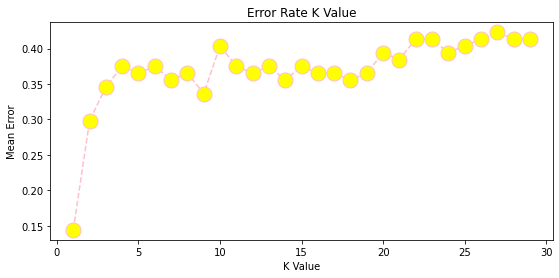

In [488]:
decisionTree = DecisionTreeClassifier(criterion='entropy', max_depth=5)
model_tree = decisionTree.fit(X_train, Y_train)

neighbors = 30

error = []
for i in range(1, neighbors):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != Y_test))

naive_bayes = GaussianNB()
model_naive = naive_bayes.fit(X_train, Y_train)

kNeighbors = KNeighborsClassifier(n_neighbors=neighbors)
model_k_nn = kNeighbors.fit(X_train, Y_train)

name_classes = model_tree.classes_

# Plotando Taxa de Erros K
plt.figure(figsize=(9, 4))
plt.plot(range(1, neighbors), error, color='pink', linestyle='dashed', marker='o',markerfacecolor='yellow', markersize=15)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# Plotando a Decision Tree

Plotando a Decision Tree de 6 niveis

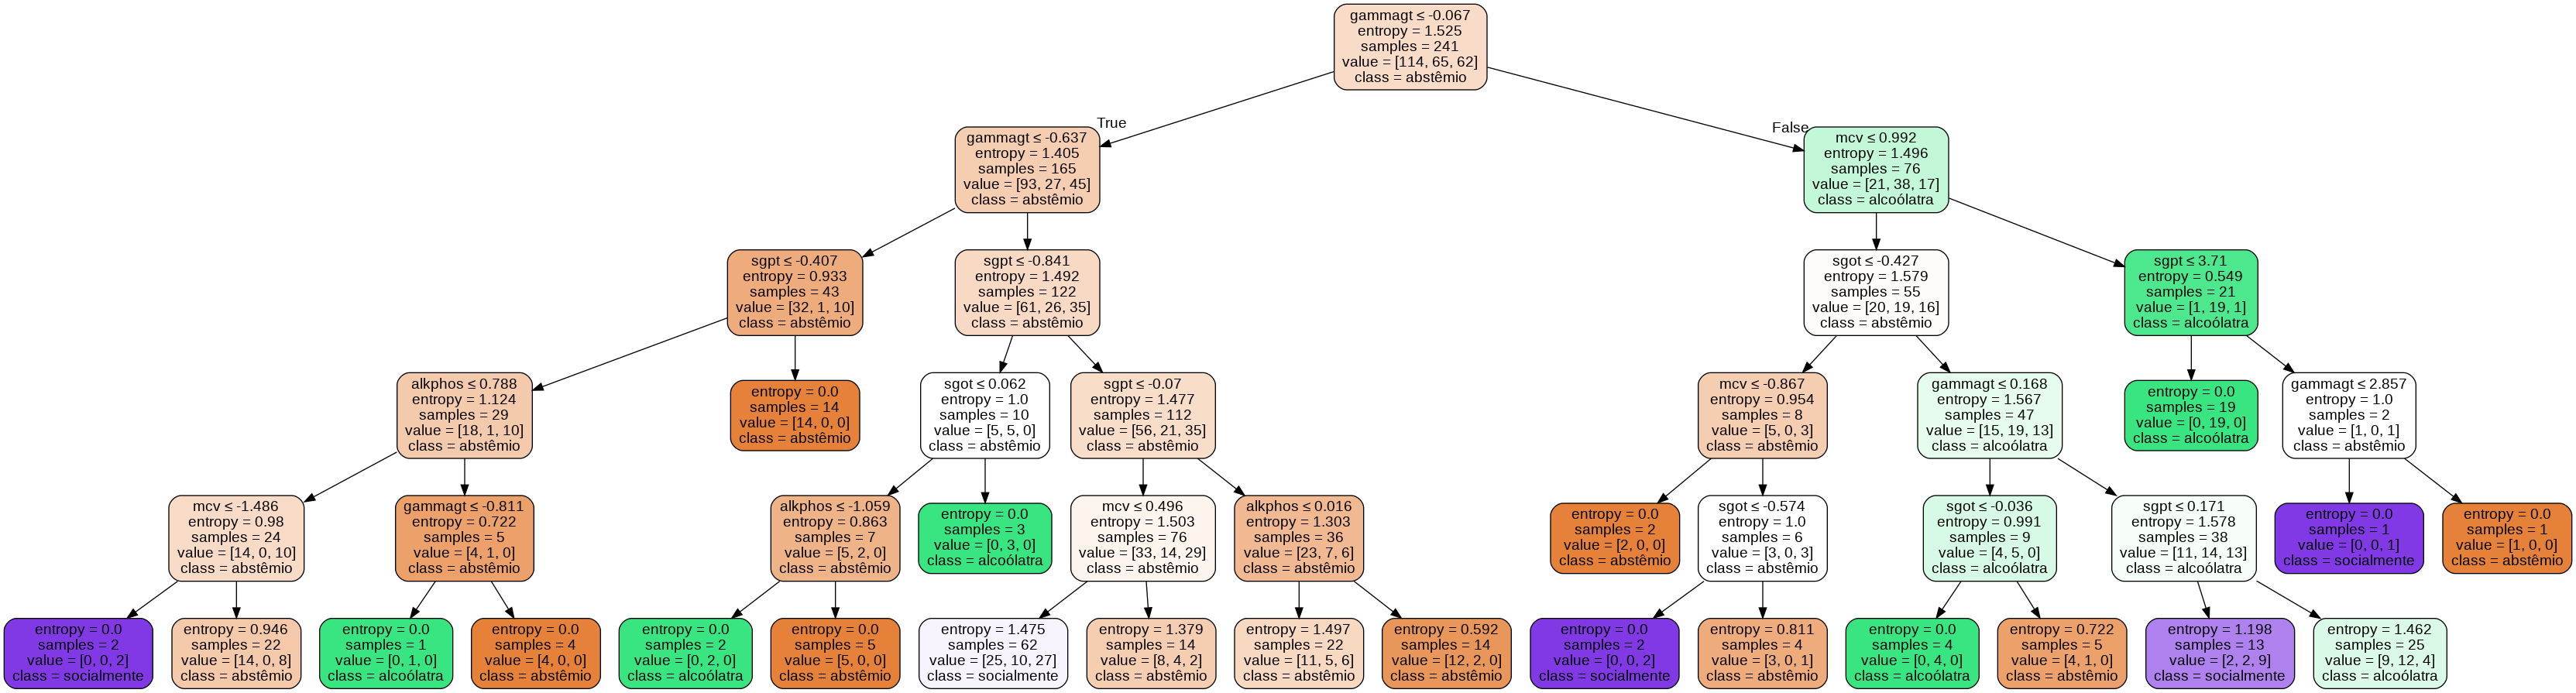

In [489]:
# Plotar a Decision Tree
dot_data = StringIO()
export_graphviz(model_tree, out_file=dot_data, filled=True, feature_names=name_features, class_names=name_classes, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
graph.write_png("model_tree.png")
Image('model_tree.png')

# Atributos mais importantes

Features de maior importância para o modelo treinado

Rank dos atributos:


1. feature 4 (0.309379) gammagt
2. feature 2 (0.263870) sgpt
3. feature 0 (0.170387) mcv
4. feature 3 (0.129479) sgot
5. feature 1 (0.126885) alkphos




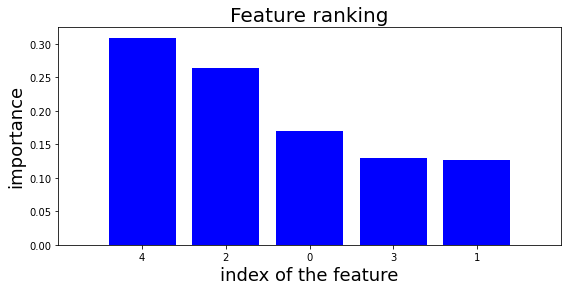

In [490]:
# ARMAZENANDO AS ETIQUETAS EM Y, CLASSES
Y = df[name_label].values

# ARMAZENANDO OS VALORES EM X, FEATURES/ATRIBUTOS
X = df[name_features].values

importances = model_tree.feature_importances_
indices = np.argsort(importances)[::-1]
print("Rank dos atributos:")
print('\n')

for f in range(X.shape[1]):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f], importances[indices[f]], name_features[indices[f]]))
print('\n')

f, ax = plt.subplots(figsize=(9, 4))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()

# Testando Modelo(Decision Tree)

* Predições;
* Matriz de Confusão.

ACURÁCIA TREE:  51.92%


              precision    recall  f1-score   support

    abstêmio       0.61      0.52      0.56        54
  alcoólatra       0.60      0.50      0.55        24
 socialmente       0.37      0.54      0.44        26

    accuracy                           0.52       104
   macro avg       0.53      0.52      0.51       104
weighted avg       0.55      0.52      0.53       104



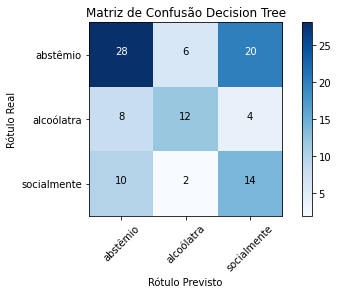

In [491]:
Y_pred_tree = model_tree.predict(X_test)

print("ACURÁCIA TREE: ", "{1:.2f}%".format("", 100 * accuracy_score(Y_test, Y_pred_tree)))
print('\n')
print(classification_report(Y_test, Y_pred_tree))

# precision:  DAS CLASSIFICAÇÕES QUE O MODELO FEZ PARA CADA CLASSE
# recall:     DOS POSSÍVEIS DATAPOINTS PERTECENTES A CADA CLASSE

matrix_confusao = confusion_matrix(Y_test, Y_pred_tree)
plt.figure()
plot_confusion_matrix(matrix_confusao, classes=name_classes, title='Decision Tree')

# Testando Modelo(Naïve Bayes)
* Predições;
* Matriz de Confusão.

ACURÁCIA NAIVE:  60.58%


              precision    recall  f1-score   support

    abstêmio       0.62      0.89      0.73        54
  alcoólatra       0.57      0.54      0.55        24
 socialmente       0.67      0.08      0.14        26

    accuracy                           0.61       104
   macro avg       0.62      0.50      0.47       104
weighted avg       0.62      0.61      0.54       104



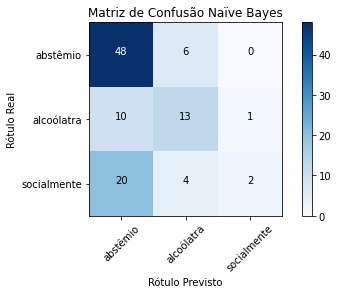

In [492]:
Y_pred_naive = model_naive.predict(X_test)

print("ACURÁCIA NAIVE: ", "{1:.2f}%".format("", 100 * accuracy_score(Y_test, Y_pred_naive)))
print('\n')
print(classification_report(Y_test, Y_pred_naive))

# precision:  DAS CLASSIFICAÇÕES QUE O MODELO FEZ PARA CADA CLASSE
# recall:     DOS POSSÍVEIS DATAPOINTS PERTECENTES A CADA CLASSE

matrix_confusao = confusion_matrix(Y_test, Y_pred_naive)
plt.figure()
plot_confusion_matrix(matrix_confusao, classes=name_classes,title='Naïve Bayes')

# Testando Modelo(k-NN)
* Predições;
* Matriz de Confusão.

ACURÁCIA k-NN:  60.58%


              precision    recall  f1-score   support

    abstêmio       0.61      0.94      0.74        54
  alcoólatra       0.59      0.42      0.49        24
 socialmente       0.67      0.08      0.14        26

    accuracy                           0.61       104
   macro avg       0.62      0.48      0.45       104
weighted avg       0.62      0.61      0.53       104



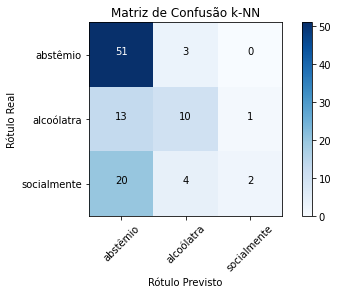

In [493]:
Y_pred_k_nn = model_k_nn.predict(X_test)

print("ACURÁCIA k-NN: ", "{1:.2f}%".format("", 100 * accuracy_score(Y_test, Y_pred_k_nn)))
print('\n')
print(classification_report(Y_test, Y_pred_k_nn))

# precision:  DAS CLASSIFICAÇÕES QUE O MODELO FEZ PARA CADA CLASSE
# recall:     DOS POSSÍVEIS DATAPOINTS PERTECENTES A CADA CLASSE

matrix_confusao = confusion_matrix(Y_test, Y_pred_k_nn)
plt.figure()
plot_confusion_matrix(matrix_confusao, classes=name_classes,title='k-NN')

# Ensemble

In [494]:
# # https://stackabuse.com/ensemble-voting-classification-in-python-with-scikit-learn/
# # https://www.kaggle.com/alexisbercion/majority-voting-ensemble

voting_clf = VotingClassifier(estimators=[('m_tree', decisionTree), ('m_naive', naive_bayes), ('m_k_nn', kNeighbors)], voting='soft')
voting_clf.fit(X_train, Y_train)
preds = voting_clf.predict(X_test)

print("ACURÁCIA Ensemble: ", "{1:.2f}%".format("", 100 * accuracy_score(Y_test, preds)))


# https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_probas.html#sphx-glr-auto-examples-ensemble-plot-voting-probas-py

ACURÁCIA Ensemble:  65.38%
